In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("../figures")

from what import WhatShift, WhatBackground, WhatNet, WhatTrainer, What, train, test, MNIST

In [4]:
from main import init
args = init(filename='../data/2019-06-12') # pas de drop out!
args.what_offset_std = 0
args.what_offset_max = 25
args.contrast = None
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 1.0,
 'contrast': None,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-05',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'what_offset_std': 0,
 'what_offset_max': 25}

## Unit tests

In [5]:
i_offset = None
j_offset = None

In [6]:
transform=transforms.Compose([
                               WhatShift(args,i_offset=i_offset, j_offset=j_offset),
                               WhatBackground(contrast = args.contrast,
                                              noise=args.noise, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])

In [7]:
dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

In [8]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [9]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

In [10]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [11]:
data, label = next(iter(train_loader))

In [12]:
label.shape

torch.Size([100])

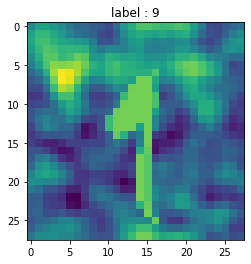

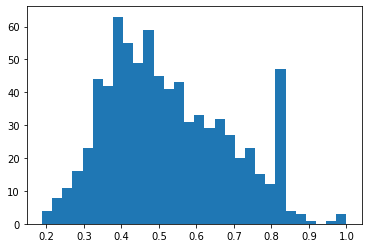

In [13]:
i = 3
plt.imshow(data[i,:,:].detach().numpy().reshape((28, 28)))
plt.title('label : '+str(label[i].item()))
plt.show()
h = plt.hist(data[i,:,:].detach().numpy().flatten(), 30)

In [14]:
device = 'cpu'
model = WhatNet().to(device)
loss_func = F.nll_loss
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

### Script d'entraînement de what_model

In [19]:
import sys, os
import datetime

In [20]:
std_max = 15

In [31]:
if args.contrast is not None:
    suffix = "robust_{}_{}_{}_{}_{}".format(args.sf_0, args.B_sf, args.noise, args.contrast, std_max)
else:
    suffix = "robust_{}_{}_{}_all_{}".format(args.sf_0, args.B_sf, args.noise, std_max)
what_model_path = "../data/MNIST_cnn_{}.pt".format(suffix)

if not os.path.isfile(what_model_path):

    debut = datetime.datetime.now()
    date = str(debut)  
    
    args.epochs = 5  # 10 plus tard
    args.save_model = True    
    args.what_offset_max = 25
    args.do_adam = True #'adam'
    
    seed = 0
    for std in range(std_max+1):
        print("En cours : std = " + str(std) + "\n")
        args.what_offset_std = std
        what_model = what.model
        what = What(args, model=what_model, force=True, seed=seed)
        seed += 1
        print("\n")

    torch.save(what_model, what_model_path)

    fin = datetime.datetime.now()
    print("\n\nDuree d'execution : " + str(fin - debut))
else:
    what_model = torch.load(what_model_path)
    what = What(args, model=what_model)



En cours : std = 0

Training the What model
Train Epoch: 1/5 [0/60000 (0%)]	Loss: 0.619433
Train Epoch: 1/5 [10000/60000 (17%)]	Loss: 0.381339
Train Epoch: 1/5 [20000/60000 (33%)]	Loss: 0.564936
Train Epoch: 1/5 [30000/60000 (50%)]	Loss: 0.406193
Train Epoch: 1/5 [40000/60000 (67%)]	Loss: 0.214297
Train Epoch: 1/5 [50000/60000 (83%)]	Loss: 0.234865

Test set: Average loss: 0.0028, Accuracy: 9134/10000 (91%)

Train Epoch: 2/5 [0/60000 (0%)]	Loss: 0.282950
Train Epoch: 2/5 [10000/60000 (17%)]	Loss: 0.200974
Train Epoch: 2/5 [20000/60000 (33%)]	Loss: 0.257482
Train Epoch: 2/5 [30000/60000 (50%)]	Loss: 0.214048
Train Epoch: 2/5 [40000/60000 (67%)]	Loss: 0.550301
Train Epoch: 2/5 [50000/60000 (83%)]	Loss: 0.295753

Test set: Average loss: 0.0026, Accuracy: 9203/10000 (92%)

Train Epoch: 3/5 [0/60000 (0%)]	Loss: 0.243362
Train Epoch: 3/5 [10000/60000 (17%)]	Loss: 0.280988
Train Epoch: 3/5 [20000/60000 (33%)]	Loss: 0.227574
Train Epoch: 3/5 [30000/60000 (50%)]	Loss: 0.344100
Train Epoch: 3/5 

Train Epoch: 2/5 [20000/60000 (33%)]	Loss: 0.537777
Train Epoch: 2/5 [30000/60000 (50%)]	Loss: 0.559570
Train Epoch: 2/5 [40000/60000 (67%)]	Loss: 0.682554
Train Epoch: 2/5 [50000/60000 (83%)]	Loss: 0.748502

Test set: Average loss: 0.0057, Accuracy: 8179/10000 (82%)

Train Epoch: 3/5 [0/60000 (0%)]	Loss: 0.676433
Train Epoch: 3/5 [10000/60000 (17%)]	Loss: 0.463492
Train Epoch: 3/5 [20000/60000 (33%)]	Loss: 0.661109
Train Epoch: 3/5 [30000/60000 (50%)]	Loss: 0.637852
Train Epoch: 3/5 [40000/60000 (67%)]	Loss: 0.434014
Train Epoch: 3/5 [50000/60000 (83%)]	Loss: 0.382277

Test set: Average loss: 0.0062, Accuracy: 8028/10000 (80%)

Train Epoch: 4/5 [0/60000 (0%)]	Loss: 0.508236
Train Epoch: 4/5 [10000/60000 (17%)]	Loss: 0.482197
Train Epoch: 4/5 [20000/60000 (33%)]	Loss: 0.450577
Train Epoch: 4/5 [30000/60000 (50%)]	Loss: 0.542299
Train Epoch: 4/5 [40000/60000 (67%)]	Loss: 0.639929
Train Epoch: 4/5 [50000/60000 (83%)]	Loss: 0.477086

Test set: Average loss: 0.0066, Accuracy: 7939/10000 (7

Train Epoch: 3/5 [50000/60000 (83%)]	Loss: 0.776488

Test set: Average loss: 0.0121, Accuracy: 5891/10000 (59%)

Train Epoch: 4/5 [0/60000 (0%)]	Loss: 1.221649
Train Epoch: 4/5 [10000/60000 (17%)]	Loss: 1.085753
Train Epoch: 4/5 [20000/60000 (33%)]	Loss: 1.035958
Train Epoch: 4/5 [30000/60000 (50%)]	Loss: 1.024786
Train Epoch: 4/5 [40000/60000 (67%)]	Loss: 1.081265
Train Epoch: 4/5 [50000/60000 (83%)]	Loss: 1.031641

Test set: Average loss: 0.0117, Accuracy: 5961/10000 (60%)

Train Epoch: 5/5 [0/60000 (0%)]	Loss: 1.008255
Train Epoch: 5/5 [10000/60000 (17%)]	Loss: 1.052898
Train Epoch: 5/5 [20000/60000 (33%)]	Loss: 1.024505
Train Epoch: 5/5 [30000/60000 (50%)]	Loss: 1.078439
Train Epoch: 5/5 [40000/60000 (67%)]	Loss: 1.227739
Train Epoch: 5/5 [50000/60000 (83%)]	Loss: 1.267537

Test set: Average loss: 0.0121, Accuracy: 5871/10000 (59%)

../data/MNIST_cnn_0.1_0.1_1.0_None_8.pt


En cours : std = 9

Training the What model
Train Epoch: 1/5 [0/60000 (0%)]	Loss: 1.415508
Train Epoch: 1/5 [

Train Epoch: 5/5 [10000/60000 (17%)]	Loss: 1.386885
Train Epoch: 5/5 [20000/60000 (33%)]	Loss: 1.558897
Train Epoch: 5/5 [30000/60000 (50%)]	Loss: 1.316144
Train Epoch: 5/5 [40000/60000 (67%)]	Loss: 1.571039
Train Epoch: 5/5 [50000/60000 (83%)]	Loss: 1.443762

Test set: Average loss: 0.0164, Accuracy: 4076/10000 (41%)

../data/MNIST_cnn_0.1_0.1_1.0_None_12.pt


En cours : std = 13

Training the What model
Train Epoch: 1/5 [0/60000 (0%)]	Loss: 1.570230
Train Epoch: 1/5 [10000/60000 (17%)]	Loss: 1.731643
Train Epoch: 1/5 [20000/60000 (33%)]	Loss: 1.784244
Train Epoch: 1/5 [30000/60000 (50%)]	Loss: 1.630866
Train Epoch: 1/5 [40000/60000 (67%)]	Loss: 1.641684
Train Epoch: 1/5 [50000/60000 (83%)]	Loss: 1.733833

Test set: Average loss: 0.0169, Accuracy: 3862/10000 (39%)

Train Epoch: 2/5 [0/60000 (0%)]	Loss: 1.798005
Train Epoch: 2/5 [10000/60000 (17%)]	Loss: 1.499866
Train Epoch: 2/5 [20000/60000 (33%)]	Loss: 1.589043
Train Epoch: 2/5 [30000/60000 (50%)]	Loss: 1.779945
Train Epoch: 2/5 [40

### General accuracy

In [32]:
acc = what.trainer.test()


Test set: Average loss: 0.0181, Accuracy: 3450/10000 (34%)



### Central accuracy

In [33]:
args.what_offset_std = 0
what = What(args, model=what_model)
acc = what.trainer.test()


Test set: Average loss: 0.0063, Accuracy: 8389/10000 (84%)



## Accuracy map calculation

In [ ]:
map_path = "../data/MNIST_accuracy_{}.npy".format(suffix)

if not os.path.isfile(map_path):
    acc_map = np.zeros((55, 55))
    seed = 0
    for i_offset in range(-27,28):
        for j_offset in range(-27,28):
            transform=transforms.Compose([
                                   WhatShift(args, i_offset=i_offset, j_offset=j_offset),
                                   WhatBackground(contrast = args.contrast,
                                                  noise=args.noise, 
                                                  sf_0=args.sf_0, 
                                                  B_sf=args.B_sf,
                                                  seed = seed),
                                   transforms.ToTensor(),
                                   #transforms.Normalize((args.mean,), (args.std,))
                               ])
            dataset_test = MNIST('../data',
                            train=False,
                            download=True,
                            transform=transform,
                            )
            test_loader = torch.utils.data.DataLoader(dataset_test,
                                             batch_size=args.minibatch_size,
                                             shuffle=True)
            whatTrainer = WhatTrainer(args, model = what_model, test_loader = test_loader, seed = seed)
            acc = whatTrainer.test()
            print(i_offset, j_offset, acc)
            acc_map[i_offset + 27, j_offset + 27] = acc
            seed += 1
    np.save(map_path, acc_map)        
else:
    acc_map = np.load(map_path)


Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-27 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -25 0.1135

Test set: Average loss: 0.0233, Accuracy: 1135/10000 (11%)

-27 -24 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -23 0.1135

Test set: Average loss: 0.0233, Accuracy: 1135/10000 (11%)

-27 -22 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -21 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-27 -20 0.1135

Test set: Average loss: 0.0281, Accuracy: 1020/10000 (10%)

-27 -19 0.102

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-27 -18 0.1135

Test set: Average loss: 0.0232, Accuracy: 1136/10000 (11%)

-27 -17 0.1136

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -16 0.1135

Test set: Average loss: 0.0232, Accuracy: 1135/10000 (11%)

-27 -15 0.1135

Test set: Av


Test set: Average loss: 0.0232, Accuracy: 958/10000 (10%)

-25 -27 0.0958

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-25 -26 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-25 -25 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-25 -24 0.1135

Test set: Average loss: 0.0231, Accuracy: 1135/10000 (11%)

-25 -23 0.1135

Test set: Average loss: 0.0232, Accuracy: 1135/10000 (11%)

-25 -22 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -21 0.1135

Test set: Average loss: 0.0233, Accuracy: 1135/10000 (11%)

-25 -20 0.1135

Test set: Average loss: 0.0233, Accuracy: 1135/10000 (11%)

-25 -19 0.1135

Test set: Average loss: 0.0231, Accuracy: 1136/10000 (11%)

-25 -18 0.1136

Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

-25 -17 0.1137

Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

-25 -16 0.1138

Test set: Average loss: 0.0230, Accuracy: 1143/10000 (11%)

-25 -15 0.1143


## Affichage Accuracy map 

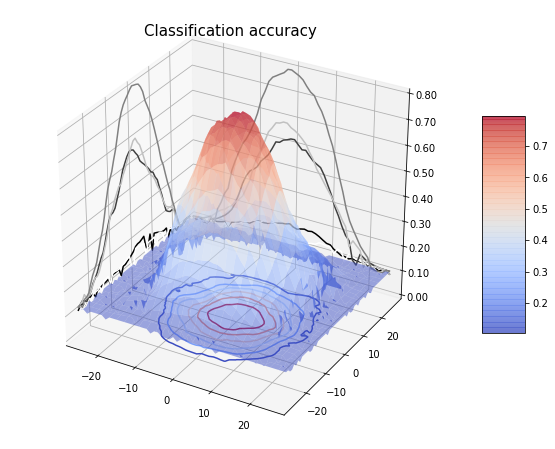

In [37]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(10,8))
for i in range(55):
    for j in range(55):
        acc_map[i,j] = max(acc_map[i,j], 0.1)

ax = fig.add_subplot(111, projection='3d')

X = np.arange(-27, 28)
Y = np.arange(-27, 28)
X, Y = np.meshgrid(X, Y)

surf = ax.plot_surface(X, Y, acc_map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True, alpha=0.5)

#ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, acc_map, [0.2, 0.3, 0.4, 0.5, 0.6, 0.7], zdir='z', offset=0, cmap=cm.coolwarm, alpha = 1)
cset = ax.contour(X, Y, acc_map, [-20, -10, 0, 10, 20], zdir='x', offset=-27.5, cmap = 'gray')
cset = ax.contour(X, Y, acc_map,  [-20, -10, 0, 10, 20], zdir='y', offset=27.5, cmap = 'gray')


# Customize the z axis.
ax.set_xlim(-27.5, 27.5)
ax.set_zlim(-27.5, 27.5)
ax.set_zlim(0, 0.8)
ax.zaxis.set_major_locator(LinearLocator(9))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('Classification accuracy', size=15)

# Add a color bar which maps values to colors.
cbar = fig.colorbar(surf, shrink=0.5, aspect=5, ticks=[0.2,0.3,0.4,0.5,0.6,0.7,0.8])

figname = '../figures/what_map'
fig.savefig(figname + '.png', bbox_inches='tight', pad_inches=0.1)
